# Logistic regression in python to discriminate between control and M. bovis infected animals based on peripheral blood transcriptomics data
### This analysis considers two approaches, one using logistic regression on variable genes that have been preprocessed using DESeq2 (vst normalised) and the other using latent variables inferred using PCA, ICA and NMF


RNA-seq data often suffers from a curse of dimensionality whereby there are many more features/genes (p) than samples (n) and this can lead to model overfitting, spurious correlations and poor generalizability. Hence, there are strategies to mitigate against this issue.
Such strategies include: applying a penalization to input features to account for multi-collinearity. Other strategies involve projecting the data into a reduced dimensional space and using these latent variabels (e.g. PCs) as input for a classification model

In [66]:
## Load in all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import kurtosis

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc, make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import warnings
import pickle
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [20]:
# Load in the data
# Note the raw will be for if individuals wish to put in a MAD filter on the data
train_data_raw = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/Train_raw_data.txt", sep = "\t").T
test_data_raw = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/Test_raw_data.txt", sep = "\t").T
train_data = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/Train_vst_normalised_data.txt", sep = "\t").T
test_data = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/Test_vst_normalised_data.txt", sep = "\t").T
train_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/Train_labels.txt", sep = "\t").T 
test_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/Test_labels.txt", sep = "\t").T.to_numpy() 

In [21]:
# Need to do some data wrangling to ensure labels are in right format for ML functions in scikit learn
# Convert labels to numeric really is the main thing
train_labels = train_labels.to_numpy()
train_labels = np.where(train_labels == "Control", 0, np.where(train_labels == "Infected", 1, train_labels))
test_labels = np.where(test_labels == "Control", 0, np.where(test_labels == "Infected", 1, test_labels))
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

I was unsure as to whether or not VST normalsied gene expression data should be scaled further (e.g. using StandardScaler) as this could increase technical noise (which would is initially removed in the VST step). However, Dr Mike love (author of DESeq2) clears it up with comments below in the context of glmnet (R package)

- "Scaling (for each gene, across samples) and VST are to some degree at odds. The VST shrinks technical variance so that biological differences are not overwhelmed. And doing so it outperforms simply transformations such as log(x + 1). But then if you force all genes to have unit variance, you undo that effect, increasing technical noise which was just shrunk.

 - I'd suggest you use the VST, then use a variance filter on the VST data to remove genes with minimal variance (take a look at the meanSdPlot to get a sense of the genes which likely have no biological signal, see vignette), then feed the remaining genes to glmnet with standardize=TRUE". - https://support.bioconductor.org/p/93160/

In [22]:
# Calcualte variances for VST normalised genes
variances = train_data.var(axis=0)
# take top 25% and filter
threshold = variances.quantile(.80) 
genes = variances > threshold
genes= genes.loc[genes==True].index
train_data = train_data.filter(items = genes, axis=1)

# Reapply to test
test_data = test_data.filter(items = genes, axis = 1)

In [23]:
# 5522 most variable genes (note this is still more than we had DE)
test_data.shape

(36, 5522)

In [24]:
# set up k fold cross validation and set random_state to 42 to ensure reproducibility
KF =  KFold(n_splits=10, shuffle=True, random_state=42)

In [25]:

# Make a pipeline for logistic regression and set the paramaters
log_pipe = Pipeline(steps=[
('scaler', StandardScaler()),
('classifier', LogisticRegression(max_iter=10000, solver='saga', tol=0.0001, random_state=42))])

precision_scorer = make_scorer(precision_score, zero_division=1)  # You can set this to 0 or 1 based on preference
f1_scorer = make_scorer(f1_score)
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score)

# Define scoring dictionary for GridSearchCV
scoring = {
    'accuracy': accuracy_scorer,
    'f1': f1_scorer,
    'precision': precision_scorer,
    'recall': recall_scorer
}

# Create a parameter grid - we will search through all these combinations
param_grid = {
    'classifier__penalty': ["elasticnet", "l1"],
    'classifier__C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'classifier__l1_ratio': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}
 
# Create GridSearchCV object
grid_search = GridSearchCV(log_pipe, param_grid, cv=KF, verbose=1, n_jobs=60, scoring=scoring, refit="accuracy")

In [26]:
# Fit the grid search
grid_search.fit(train_data, train_labels.ravel())

Fitting 10 folds for each of 220 candidates, totalling 2200 fits


/home/workspace/jogrady/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/workspace/jogrady/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/workspace/jogrady/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/workspace/jogrady/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/workspace/jogrady/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pena

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=60,
             param_grid={'classifier__C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.07, 0.08, 0.09, 0.1],
                         'classifier__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1],
                         'classifier__penalty': ['elasticnet', 'l1']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)},
             verbose=1)

In [27]:
# Look at best paramaters and accuracy and save results to a data frame

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
results_genes = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_accuracy"], columns = ["Average Accuracy"]),
           pd.DataFrame(grid_search.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_precision"], columns = ["Average precision"]),
           pd.DataFrame(grid_search.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_recall"], columns=["Average recall"]),
           pd.DataFrame(grid_search.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_genes.sort_values(by='Average Accuracy', inplace=True)


Best Parameters: {'classifier__C': 0.09, 'classifier__l1_ratio': 0, 'classifier__penalty': 'elasticnet'}
Best Score: 0.9180555555555555


In [28]:
results_genes

,classifier__C,classifier__l1_ratio,classifier__penalty,Average Accuracy,SD accuracy,Average precision,SD precision,Average recall,SD recall
77,0.04,0.5,l1,0.379167,0.210365,0.833333,0.334258,0.2000,0.400000
75,0.04,0.4,l1,0.379167,0.210365,0.833333,0.334258,0.2000,0.400000
83,0.04,0.8,l1,0.379167,0.210365,0.833333,0.334258,0.2000,0.400000
73,0.04,0.3,l1,0.379167,0.210365,0.833333,0.334258,0.2000,0.400000
71,0.04,0.2,l1,0.379167,0.210365,0.833333,0.334258,0.2000,0.400000
...,...,...,...,...,...,...,...,...,...
132,0.07,0.0,elasticnet,0.906944,0.072979,0.910000,0.147611,0.9175,0.106095
66,0.04,0.0,elasticnet,0.906944,0.072979,0.910000,0.147611,0.9175,0.106095
154,0.08,0.0,elasticnet,0.906944,0.072979,0.910000,0.147611,0.9175,0.106095
198,0.10,0.0,elasticnet,0.918056,0.077691,0.943333,0.124766,0.9175,0.106095


In [29]:
# Save model in case we ever need it again e.g. for external data
with open('/home/workspace/jogrady/ML4TB/work/models/Logistic_regression_CV_search.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

In [30]:
confusion_matrix(grid_search.predict(test_data), test_labels.ravel())

array([[16,  3],
       [ 2, 15]])

In [76]:
target_names = ['Control', 'Infected']
print(classification_report(test_labels.ravel(), grid_search.predict(test_data), target_names=target_names))
Gene_cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels.ravel(),grid_search.predict(test_data)), display_labels = ["Control", "Infected"])

              precision    recall  f1-score   support

     Control       0.84      0.89      0.86        18
    Infected       0.88      0.83      0.86        18

    accuracy                           0.86        36
   macro avg       0.86      0.86      0.86        36
weighted avg       0.86      0.86      0.86        36



# Using latent variables as a means of reducing dimensionality and extracting biological insight

### 1. PCA

People generally choose the elbow method for picking the optimal number of PCs. However, others choose the numbr of PCs that explain e.g 80, 90 95% of the variation as input. Unclear which is best so we will settle for 80% as an upper limit and evaluate the contribution of differening number of PCs before picking the best model to evaluate on the test set

- Side point: The number of PCs is important to specify for ICA

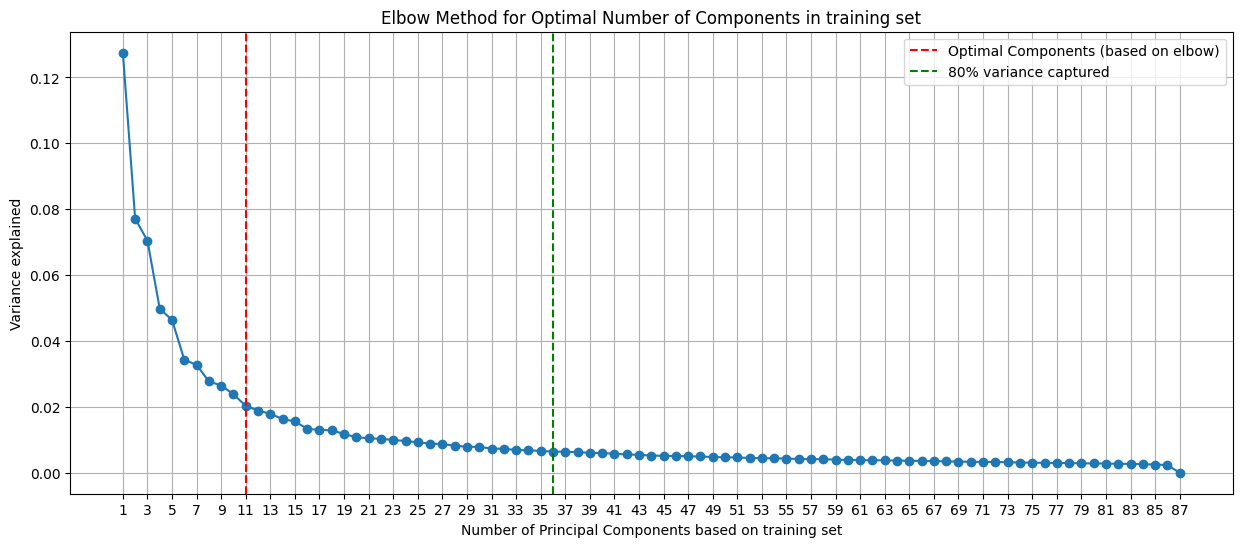

Variance captured by 36 PCs:0.80


In [32]:
 
# Do not need to scale for PCA - not recommended in VST
pca = PCA(random_state=88, n_components=87)
pca.fit(train_data)
explained_variance = pca.explained_variance_ratio_
# Plotting the elbow curve
plt.figure(figsize=(15, 6))
plt.plot(range(1, 87 + 1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components based on training set')
plt.ylabel('Variance explained')
plt.title('Elbow Method for Optimal Number of Components in training set')
plt.grid()
plt.xticks(range(1, 87 + 1,2))
plt.axvline(x=11, color='r', linestyle='--', label='Optimal Components (based on elbow)')
plt.axvline(x=36, color='g', linestyle='--', label='80% variance captured')
plt.legend()
plt.show()
print(f'Variance captured by 36 PCs:{pca.explained_variance_ratio_[:36].sum():.2f}')


In [33]:
PCA_Pipeline = Pipeline(steps=[('pca', PCA()),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

pca_param_grid = {'pca__n_components': list(range(1, 37))}

LR_pca_search_model = GridSearchCV(PCA_Pipeline, pca_param_grid, cv=KF, scoring=scoring, refit="accuracy")

LR_pca_search_model.fit(train_data, train_labels.ravel())

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [34]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_pca_search_model.best_params_)
print("Best Score:", LR_pca_search_model.best_score_)
results_pca = pd.concat([pd.DataFrame(LR_pca_search_model.cv_results_["params"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_pca.sort_values(by='CV Accuracy', inplace=True)

Best Parameters: {'pca__n_components': 30}
Best Score: 0.9069444444444444


In [35]:
results_pca

,pca__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
2,3,0.619444,0.145959,0.596667,0.164114,0.709643,0.222199
1,2,0.620833,0.165744,0.603333,0.165462,0.697143,0.243197
0,1,0.644444,0.144765,0.616667,0.175119,0.729643,0.220424
3,4,0.688889,0.123946,0.696667,0.224697,0.723929,0.217394
10,11,0.711111,0.109854,0.703095,0.245254,0.767143,0.206506
4,5,0.731944,0.131329,0.785000,0.199785,0.703095,0.179922
6,7,0.755556,0.175594,0.794762,0.207328,0.774643,0.219417
9,10,0.758333,0.144898,0.758333,0.230850,0.767143,0.206506
8,9,0.766667,0.180106,0.819762,0.215341,0.774643,0.219417
5,6,0.768056,0.152910,0.839762,0.180319,0.743929,0.232171


In [77]:
print(classification_report(test_labels.ravel(), LR_pca_search_model.predict(test_data), target_names=target_names))
PCA_cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels.ravel(),LR_pca_search_model.predict(test_data)), display_labels = ["Control", "Infected"])

              precision    recall  f1-score   support

     Control       0.84      0.89      0.86        18
    Infected       0.88      0.83      0.86        18

    accuracy                           0.86        36
   macro avg       0.86      0.86      0.86        36
weighted avg       0.86      0.86      0.86        36



### 2. ICA

ICA and PCA are similar to each other however ICA attemps to transform the data into statistically significant non-Gaussian components. Often times this is estimated by Kurtosis but the number of  !'PCs'! used for the whitening procedure is often those that reach 80,90,95% etc, hence we will use this for below  

In [37]:
# ICA
from sklearn.decomposition import FastICA
ICA_transformer = FastICA(n_components=36, # from PCA - 80% of variance
        random_state=42,
        max_iter=1000, tol=0.0001,
        whiten='unit-variance')

df_train_ica = ICA_transformer.fit_transform(train_data)
kurtosis_scores = [kurtosis(df_train_ica[:, i]) for i in range(df_train_ica.shape[1])]
n_components = np.argmax(kurtosis_scores) + 1

In [38]:
# Number of non-normal components in training data = 14 - however we will use the same as above for PCA
n_components

14

In [45]:
ICA_Pipeline = Pipeline(steps=[('ica', FastICA( # from PCA - 80% of variance
        random_state=42,
        max_iter=5000, tol=0.0001,
        whiten='unit-variance')),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

pca_param_grid = {'ica__n_components': list(range(1, 37))}

LR_ica_search_model = GridSearchCV(ICA_Pipeline, ica_param_grid, cv=KF, scoring=scoring, refit="accuracy")

LR_ica_search_model.fit(train_data, train_labels.ravel())


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ica',
                                        FastICA(max_iter=5000,
                                                random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'ica__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [46]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_ica_search_model.best_params_)
print("Best Score:", LR_ica_search_model.best_score_)
results_ica = pd.concat([pd.DataFrame(LR_pca_search_model.cv_results_["params"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_ica_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_ica.sort_values(by='CV Accuracy', inplace=True)

Best Parameters: {'ica__n_components': 35}
Best Score: 0.9291666666666666


In [47]:
results_ica

,pca__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
1,2,0.619444,0.191767,0.623333,0.197090,0.682857,0.254113
2,3,0.631944,0.140443,0.611667,0.170465,0.709643,0.222199
0,1,0.654167,0.171734,0.653333,0.198858,0.715357,0.234401
3,4,0.688889,0.147012,0.708333,0.221140,0.709643,0.222199
4,5,0.700000,0.078124,0.696667,0.242418,0.736429,0.199858
10,11,0.711111,0.109854,0.703095,0.245254,0.767143,0.206506
6,7,0.744444,0.170239,0.794762,0.207328,0.754643,0.225233
7,8,0.755556,0.175594,0.819762,0.215341,0.749643,0.234523
5,6,0.756944,0.139062,0.814762,0.173574,0.743929,0.232171
9,10,0.758333,0.144898,0.758333,0.230850,0.767143,0.206506


In [151]:
print(classification_report(test_labels.ravel(),LR_ica_search_model.predict(test_data), target_names=target_names))
ICA_cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels.ravel(),LR_ica_search_model.predict(test_data)), display_labels = ["Control", "Infected"])
# display matrix

              precision    recall  f1-score   support

     Control       0.80      0.89      0.84        18
    Infected       0.88      0.78      0.82        18

    accuracy                           0.83        36
   macro avg       0.84      0.83      0.83        36
weighted avg       0.84      0.83      0.83        36



### 3. Non-negative matrix factorization

In [52]:

NMF_Pipeline = Pipeline(steps=[('nmf', NMF(
    init="random", solver='cd', 
    beta_loss='frobenius', tol=0.0001, 
    max_iter=10000, random_state=42, verbose=0)),
('classifier', LogisticRegression(max_iter=10000, penalty=None, solver='saga', tol=0.0001, random_state=42))])

nmf_param_grid = {'nmf__n_components': list(range(1, 37))}

LR_nmf_search_model = GridSearchCV(NMF_Pipeline, nmf_param_grid, cv=KF, n_jobs= 30, scoring=scoring, refit="accuracy")

LR_nmf_search_model.fit(train_data, train_labels.ravel())

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('nmf',
                                        NMF(init='random', max_iter=10000,
                                            random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty=None,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=30,
             param_grid={'nmf__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [53]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", LR_nmf_search_model.best_params_)
print("Best Score:", LR_nmf_search_model.best_score_)
results_ica = pd.concat([pd.DataFrame(LR_pca_search_model.cv_results_["params"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_nmf_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_ica.sort_values(by='CV Accuracy', inplace=True)

Best Parameters: {'nmf__n_components': 33}
Best Score: 0.9069444444444444


In [55]:
results_ica

,pca__n_components,CV Accuracy,SD accuracy,CV precision,SD precision,CV recall,SD recall
0,1,0.569444,0.207591,0.660000,0.269485,0.566905,0.293502
4,5,0.641667,0.196301,0.635000,0.166908,0.701071,0.254901
3,4,0.654167,0.178779,0.650000,0.209762,0.709643,0.222199
2,3,0.666667,0.171796,0.665000,0.211009,0.709643,0.222199
5,6,0.687500,0.116906,0.710000,0.241431,0.690595,0.197118
1,2,0.690278,0.168056,0.706667,0.224870,0.709643,0.222199
11,12,0.700000,0.128980,0.703095,0.245254,0.754643,0.225233
10,11,0.734722,0.138673,0.741667,0.218486,0.754643,0.225233
6,7,0.743056,0.196541,0.814762,0.216320,0.735357,0.248857
12,13,0.744444,0.078124,0.703333,0.199555,0.786429,0.162174


In [80]:
print(classification_report(test_labels.ravel(), LR_nmf_search_model.predict(test_data), target_names=target_names))
NMF_cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels.ravel(),LR_nmf_search_model.predict(test_data)), display_labels = ["Control", "Infected"])

              precision    recall  f1-score   support

     Control       0.85      0.94      0.89        18
    Infected       0.94      0.83      0.88        18

    accuracy                           0.89        36
   macro avg       0.89      0.89      0.89        36
weighted avg       0.89      0.89      0.89        36



## Evaluation
### 1. Confusion matrix
 - Note, this is based on a theta value of 0.5.

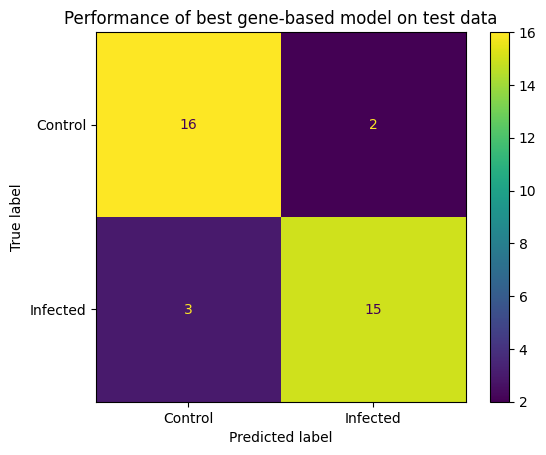

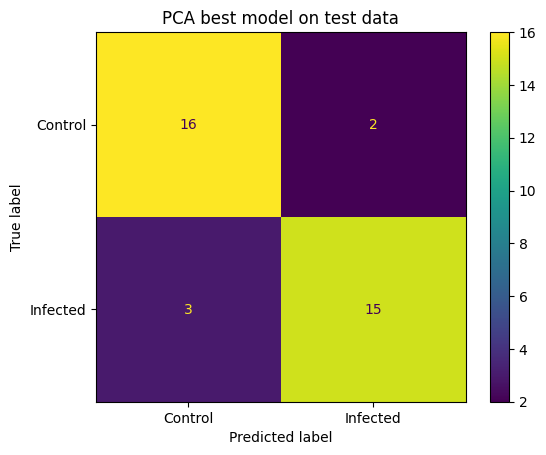

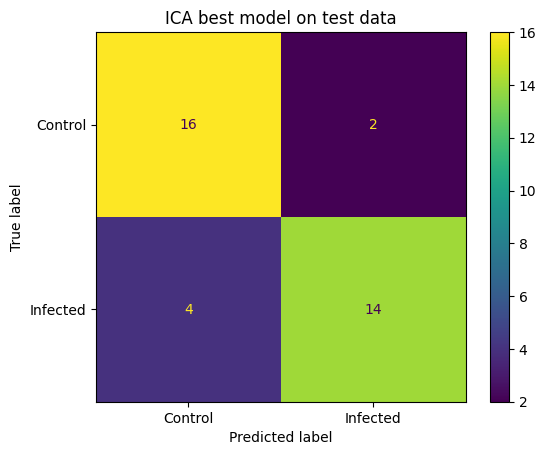

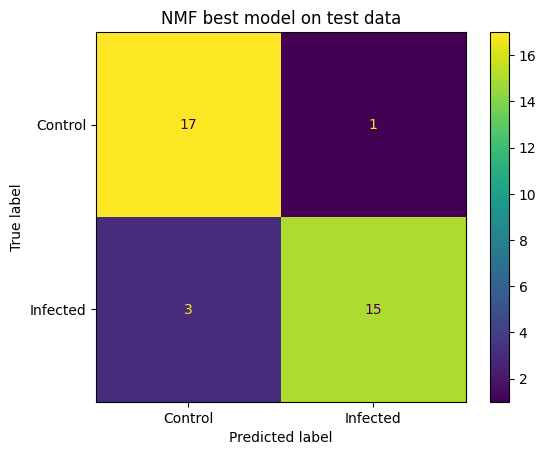

In [152]:
# Genes
Gene_cm_display.plot()
plt.title("Performance of best gene-based model on test data")

# PCA
PCA_cm_display.plot()
plt.title('PCA best model on test data')

# ICA
ICA_cm_display.plot()
plt.title('ICA best model on test data')

# NMF
NMF_cm_display.plot()
plt.title('NMF best model on test data')

plt.show()


### 2. ROC curve

In [96]:
# predict continuous value
# For different decision thresholds
y_score_gene = grid_search.predict_proba(test_data)
fprG_gene, tprG_gene, t_gene = roc_curve(test_labels.ravel(), y_score_gene[:,1])
roc_aucG_gene = auc(fprG_gene, tprG_gene)


y_score_pca = LR_pca_search_model.predict_proba(test_data)
fprG_pca, tprG_pca, t_pca = roc_curve(test_labels.ravel(), y_score_pca[:,1])
roc_aucG_pca = auc(fprG_pca, tprG_pca)


y_score_ica = LR_pca_search_model.predict_proba(test_data)
fprG_ica, tprG_ica, t_ica = roc_curve(test_labels.ravel(), y_score_ica[:,1])
roc_aucG_ica = auc(fprG_ica, tprG_ica)



y_score_nmf = LR_pca_search_model.predict_proba(test_data)
fprG_nmf, tprG_nmf, t_nmf = roc_curve(test_labels.ravel(), y_score_nmf[:,1])
roc_aucG_nmf = auc(fprG_nmf, tprG_nmf)

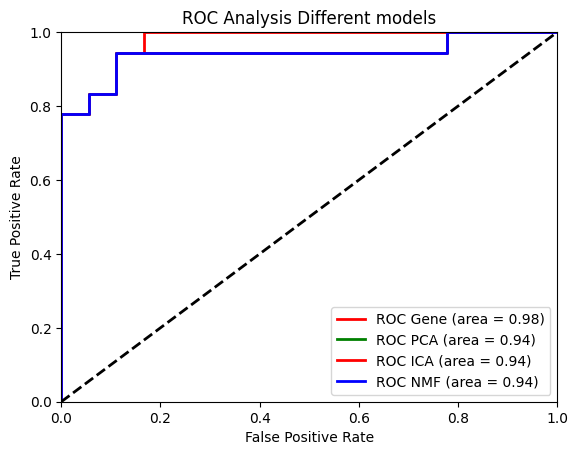

In [103]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(fprG_gene, tprG_gene, color='red',
         lw=lw, label='ROC Gene (area = %0.2f)' % roc_aucG_gene)
plt.plot(fprG_pca, tprG_pca, color='green',
         lw=lw, label='ROC PCA (area = %0.2f)' % roc_aucG_pca)
plt.plot(fprG_ica, tprG_ica, color='red',
         lw=lw, label='ROC ICA (area = %0.2f)' % roc_aucG_ica)
plt.plot(fprG_nmf, tprG_nmf, color='blue',
         lw=lw, label='ROC NMF (area = %0.2f)' % roc_aucG_nmf)

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis Different models')
plt.legend(loc="lower right")
plt.show()

# Bite NMF covers both PCA and ICA as they are identical

### 3. Look at coefficients of model.

In [147]:
grid_search.best_estimator_.named_steps['classifier'].coef_
coefficient_data_frame = pd.DataFrame({"GeneID": np.array(train_data.columns),
                                       "Coefficient": grid_search.best_estimator_.named_steps['classifier'].coef_.ravel()})
coefficient_data_frame

In [148]:
coefficient_data_frame

,GeneID,Coefficient
0,ENSBTAG00000054829,0.004747
1,ENSBTAG00000021997,0.002041
2,ENSBTAG00000030814,-0.002267
3,ENSBTAG00000021280,0.013247
4,ENSBTAG00000023398,0.007561
...,...,...
5517,ENSBTAG00000052584,-0.001104
5518,ENSBTAG00000052012,0.014595
5519,ENSBTAG00000024874,-0.010291
5520,ENSBTAG00000054081,0.005043
